## quantum_svm_mnist_ionq.py

In [27]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from qiskit_ionq import IonQProvider
from qiskit import QuantumCircuit

from qiskit_aer import Aer
from tqdm import tqdm


In [28]:
mnist = fetch_openml('mnist_784', version=1)
X_raw, y_raw = mnist['data'], mnist['target']

In [29]:
# 2. Filter for digits 3 and 6
mask = (y_raw == '3') | (y_raw == '6')
X, y = X_raw[mask], y_raw[mask]

# Reduce the number of samples for each class
n_samples_per_class = 100  # adjust as needed
X_small = []
y_small = []
for label in ['3', '6']:
    idx = np.where(y == label)[0][:n_samples_per_class]
    X_small.append(X.iloc[idx])
    y_small.append(y.iloc[idx])
X = np.vstack([x.values for x in X_small])
y = np.concatenate(y_small)

# 3. Relabel: 3 → 0, 6 → 1
y = np.where(y == '3', 0, 1)

# 4. PCA for dimensionality reduction
n_components = 4  # Adjust for your quantum circuit size
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

# 5. Standard Scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

# 6. Train-test split
indices = np.arange(len(X))
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_scaled, y, indices, test_size=0.2, random_state=42
)


In [30]:
# 7. Setup IonQ backend (Qiskit)
# provider = IonQProvider(token='YOUR_IONQ_API_KEY')
# backend = provider.get_backend('ionq_simulator')  # or 'ionq_qpu' for hardware
backend = None  # TODO: Set up IonQ backend with your API key
backend = Aer.get_backend("aer_simulator")

# 8. Angle Embedding and Adjoint Embedding
def angle_embedding(x, n_qubits):
    qc = QuantumCircuit(n_qubits)
    for i, val in enumerate(x):
        qc.ry(val, i)
    return qc

def adjoint_angle_embedding(x, n_qubits):
    qc = angle_embedding(x, n_qubits)
    return qc.inverse()

# 9. Kernel Matrix Setup (Quantum Kernel Evaluation)
# def quantum_kernel_matrix(X1, X2, backend, n_qubits):
#     # TODO: Implement quantum kernel evaluation using IonQ backend
#     # For now, return a random matrix as a placeholder
#     return np.random.rand(len(X1), len(X2))

def quantum_kernel_matrix(X1, X2, backend, n_qubits, shots=1024):
    kernel_matrix = np.zeros((len(X1), len(X2)))
    for i, x1 in enumerate(tqdm(X1, desc="Rows", position=0)):
        for j, x2 in enumerate(tqdm(X2, desc="Cols", position=1, leave=False)):
            qc = angle_embedding(x1, n_qubits)
            qc.compose(adjoint_angle_embedding(x2, n_qubits), inplace=True)
            qc.measure_all()
            job = backend.run(qc, shots=shots)
            result = job.result()
            counts = result.get_counts()
            prob_zero = counts.get('0'*n_qubits, 0) / shots
            kernel_matrix[i, j] = prob_zero
    return kernel_matrix

In [31]:
# 10. Create SVM with precomputed kernel
K_train = quantum_kernel_matrix(X_train, X_train, backend, n_components)
K_test = quantum_kernel_matrix(X_test, X_train, backend, n_components)

svm = SVC(kernel='precomputed')
svm.fit(K_train, y_train)

# 11. Evaluate SVM
y_pred = svm.predict(K_test)
acc = accuracy_score(y_test, y_pred)
print(f'Quantum SVM accuracy: {acc:.3f}')

Rows: 100%|██████████| 40/40 [00:06<00:00,  6.45it/s]

Quantum SVM accuracy: 1.000


In [32]:
correct_indices = np.where(y_pred == y_test)[0]
n_examples = 5
show_indices = correct_indices[:n_examples]

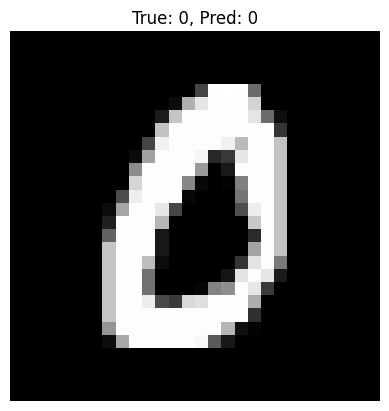

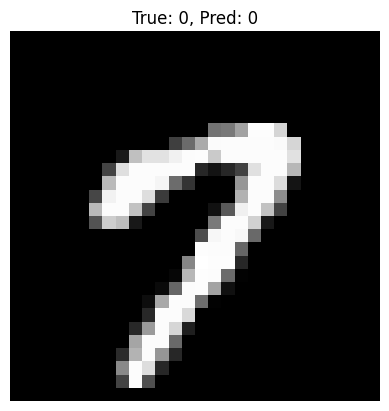

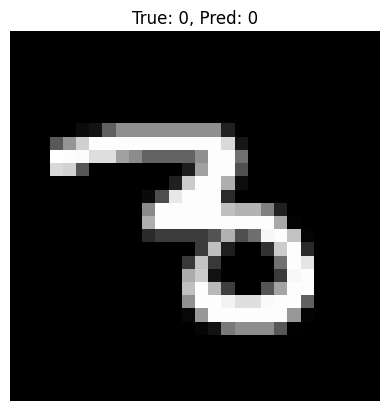

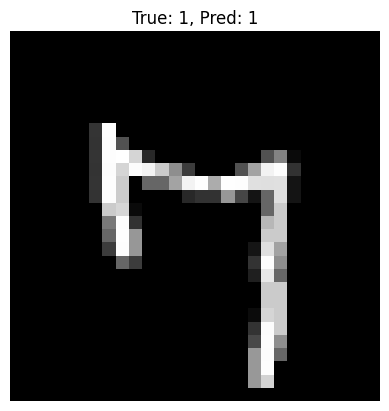

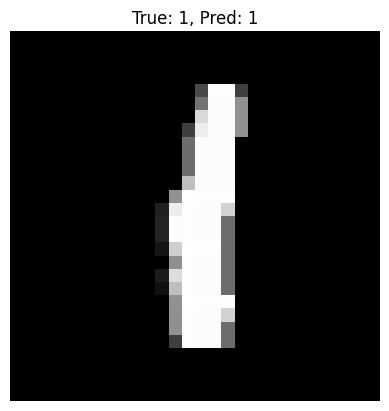

In [33]:
# Find correct predictions
for idx in show_indices:
    orig_idx = idx_test[idx]
    img = X_raw.iloc[orig_idx].values.reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {y_test[idx]}, Pred: {y_pred[idx]}")
    plt.axis('off')
    plt.show()